In [2]:
#----------------------
#
#Szki programu na podstawie
#doi:10.1371/journal.pone.0033501
#
#napisany około 05.02.2024
#
#----------------------

import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random

## Parametry (replika figury 4)

In [51]:
# symulacja będzie prowadzona na siatce 2D o wymiarach 100 x 100

Lx, Ly = 60, 60
dt = 0.01
dx = 0.05
dy = 0.05
Nx, Ny = int(Lx/dx), int(Ly/dy)

# parametry typów komórek

tau_u = 1
D = [0.001]

eta_s = [0]
eta = [[0]]
gamma = [0]
alpha = [1]
beta = [[1]]
beta_s = [0]

V_max = [1]


L = 1

## Równania

In [109]:
# 1>=f>=0
def h(f):
    return f*f*(3-2*f)

# bezpośrednio związane z warunkami brzegowymi (tutaj - sferyczne)
def laplacian(f):
    L = (np.roll(f,-1,axis=0)+np.roll(f,1,axis=0)-2*f)/(dx*dx)
    L += (np.roll(f,-1,axis=1)+np.roll(f,1,axis=1)-2*f)/(dy*dy)
    return L

def kdelta(i,j):
    if i==j:
        return 1
    return 0

#wprowadzanie dużego wektora macierzy do każdej funkcji jako argumentu jest bardzo niepraktyczne i podczas dopracowywania kodu trzeba będzie zmienić ten sposób deklaracji funkcji
def volume(u,i,m):
    return np.sum(h(u[i][m]))*dx*dy

def phi_calc(u,i):
    result = np.zeros((Nx,Ny))
    for uim in u[i]:
        result += uim
    return result

def sum_u(u,i):
    result = np.zeros((Nx,Ny))
    for uim in u[i]:
        result += h(uim)
    return result

def generate_cell(xcenter, ycenter, radius=0.5, smoothness=1):
    matrix = np.zeros((Nx, Ny))
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    return -np.tanh(smoothness * (np.sqrt((xv-xcenter)**2 + (yv-ycenter)**2) - radius))/2 + 1/2

def take_position(u,i,m):
    Nx, Ny = u[i][m].shape
    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)

    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)

    X, Y = np.meshgrid(x, y, indexing='ij')

    total_mass = np.sum(u[i][m])
    com_x = np.sum(X * u[i][m]) / total_mass
    com_y = np.sum(Y * u[i][m]) / total_mass

    return com_x, com_y

def cell_divide(u,i,m,volLim,smoothness):
    volu = volume(u,i,m)
    if volLim>V_max[i]:
        raise ValueError("volume limit for cell division should be smaller than absolute volume limit for given specie")
    elif volu<volLim:
        return
    else:
        new_radius = np.sqrt(volu/np.pi/2)
        theta = random.uniform(0, 2*np.pi)
        omega_x, omega_y = np.cos(theta), np.sin(theta)
        com_x, com_y = take_position(u,i,m)
        com = com_x, com_y
        # poniższy meshgrid jest w tej samej postaci wykorzystywany podczas liczenia środka masy
        matrix = np.zeros((Nx, Ny))
        x = np.linspace(0, Lx, Nx)
        y = np.linspace(0, Ly, Ny)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        new_u_1 = (np.tanh(smoothness * (omega_x*(xv-com_x)+omega_y*(yv-com_y))) + 1)*u[i][m]/2
        new_u_2 = (-np.tanh(smoothness * (omega_x*(xv-com_x)+omega_y*(yv-com_y))) + 1)*u[i][m]/2
         
        u[i][m]=new_u_1
        u[i].append(new_u_2)


# u[i][m]
u = [[]]
phi_arr = []

u[0].append(generate_cell(30,30,0.5,5))

s = np.zeros((Nx,Ny))

phi_arr.append(sum_u(u,0))

def gs(u,i,m, s):
    return eta[i]*u[i][m]*(1-u[i][m])*laplacian(h(s))

def gint(u,i,m,phi):
    result = eta[i][i]*u[i][m]*(1-u[i][m])*laplacian(phi[i]-h(u[i][m])*kdelta(i,i))
    return result + gamma[i]*u[i][m]*(1-u[i][m])*laplacian(h(u[i][m]))

def f_term(u,i,m,s,phi):
    result = alpha[i]*(V_max[i]-volume(u,i,m))
    result += -beta[i][i]*(phi[i]-h(u[i][m])*kdelta(0,0))
    return result - beta_s[i]*h(s)

def time_differential_equation(u,i,m,s,phi):
    result = D[i]*laplacian(u[i][m])
    result += u[i][m]*(1-u[i][m])*(u[i][m]-0.5+f_term(u,i,m,s,phi))
    result += gint(u,i,m,phi)
    result += gs(u,i,m,s)
    return result/tau_u

## Plot functions

In [110]:
def plot_contour(Z, t, numOfCells):
    levels = [0.5]
    x = np.linspace(0, 60, Z.shape[0])
    y = np.linspace(0, 60, Z.shape[1])
    X, Y = np.meshgrid(x, y)
    
    plt.contour(Y, X, Z.T, levels, colors='black', linewidths=0.5)  # Transpose Z to match the meshgrid orientation
    plt.title(f"$timestep = {t}, num of cells = {numOfCells}$")
    plt.grid(True)

def plot_all(Z, i, t, numOfCells):
    for j in Z[i]:
        plot_contour(j, t, numOfCells)
    

def plot_value(Z, t, numOfCells):
    plt.imshow(Z, extent=(0, 60, 0, 60), cmap='copper')
    #plt.colorbar()
    plt.title(f"$timestep = {t}, num of cells = {numOfCells}$")

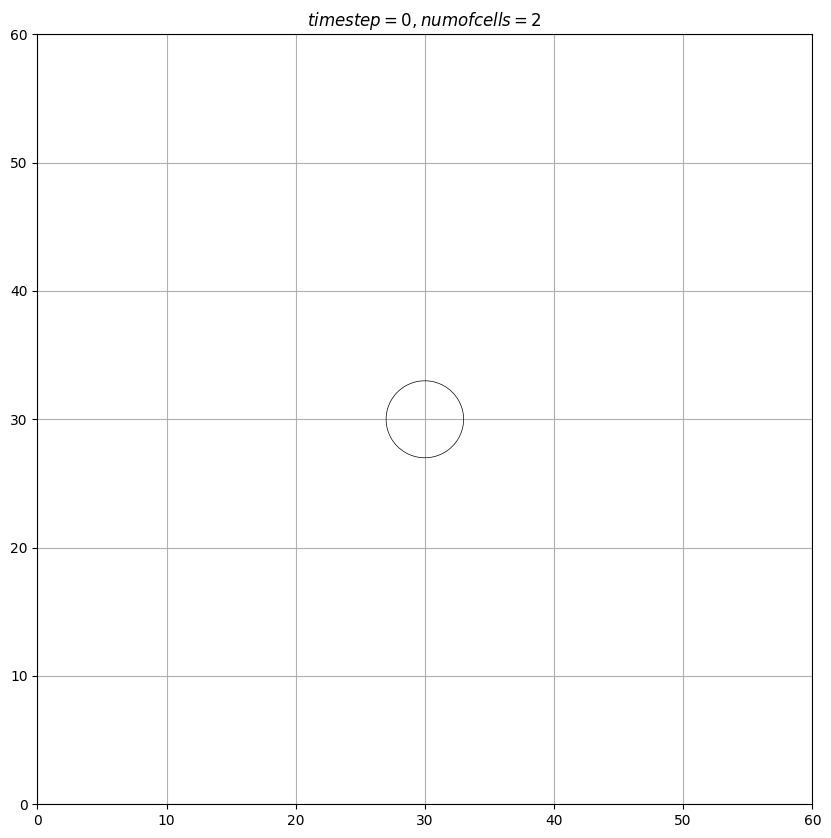

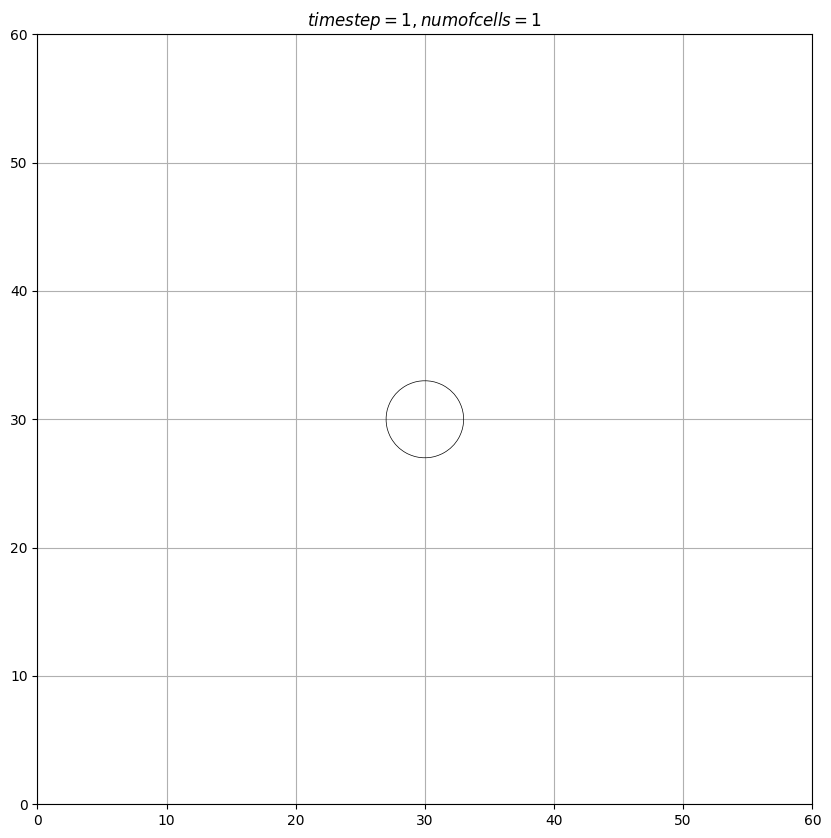

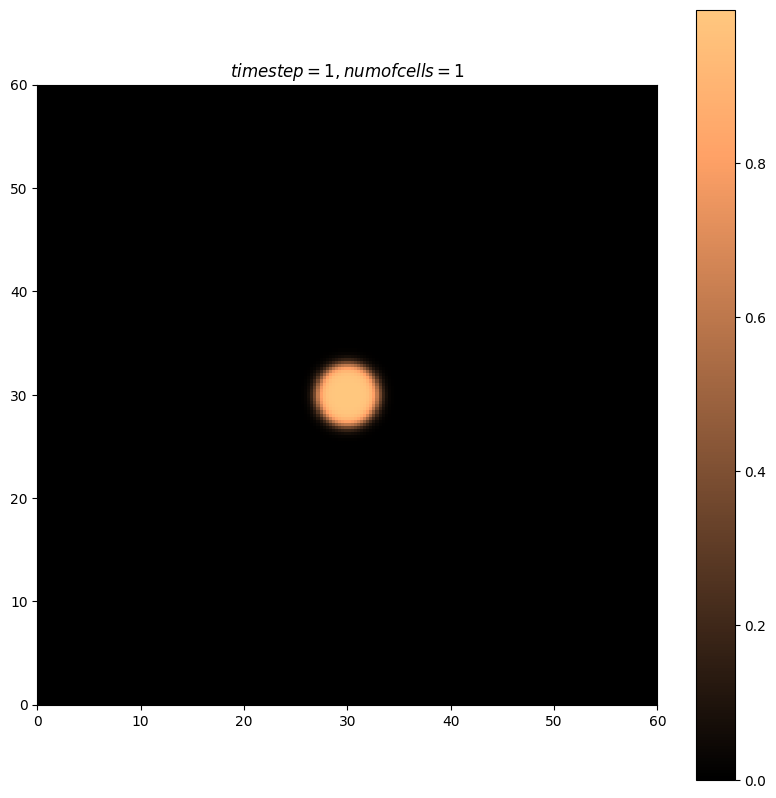

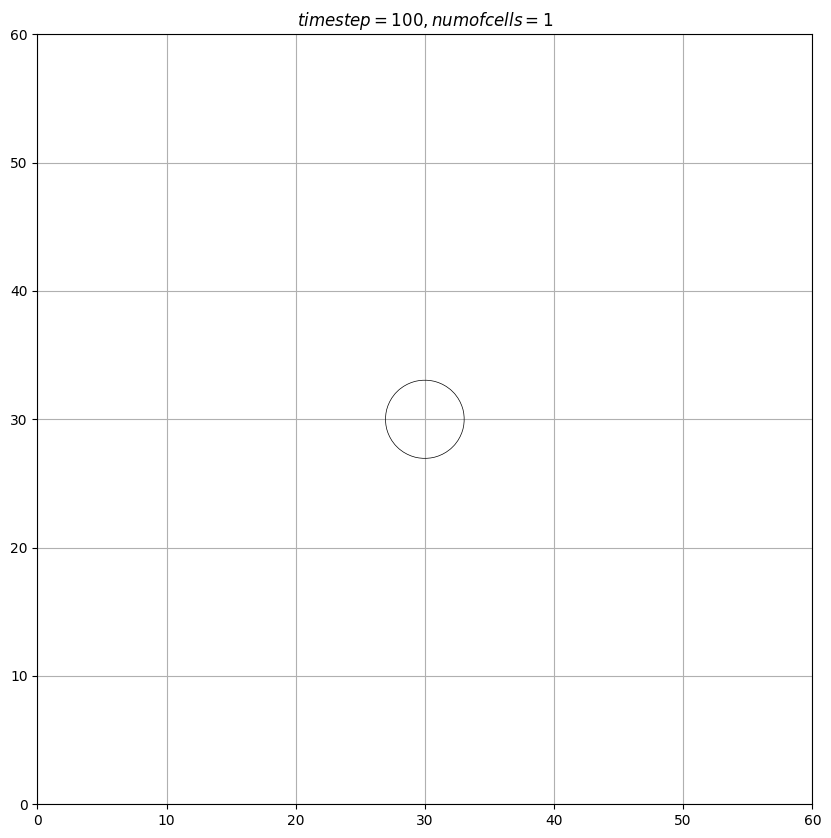

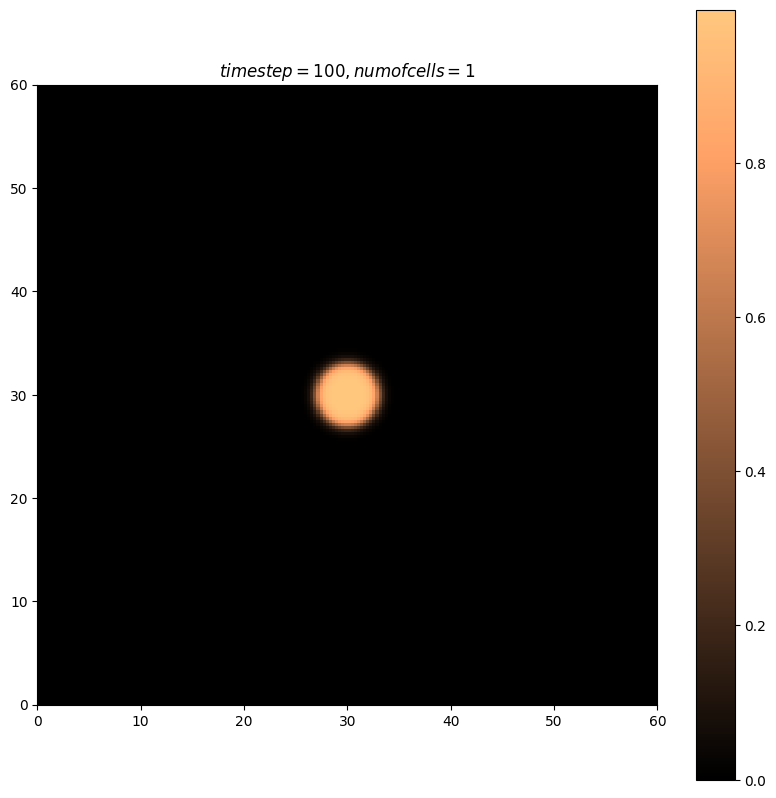

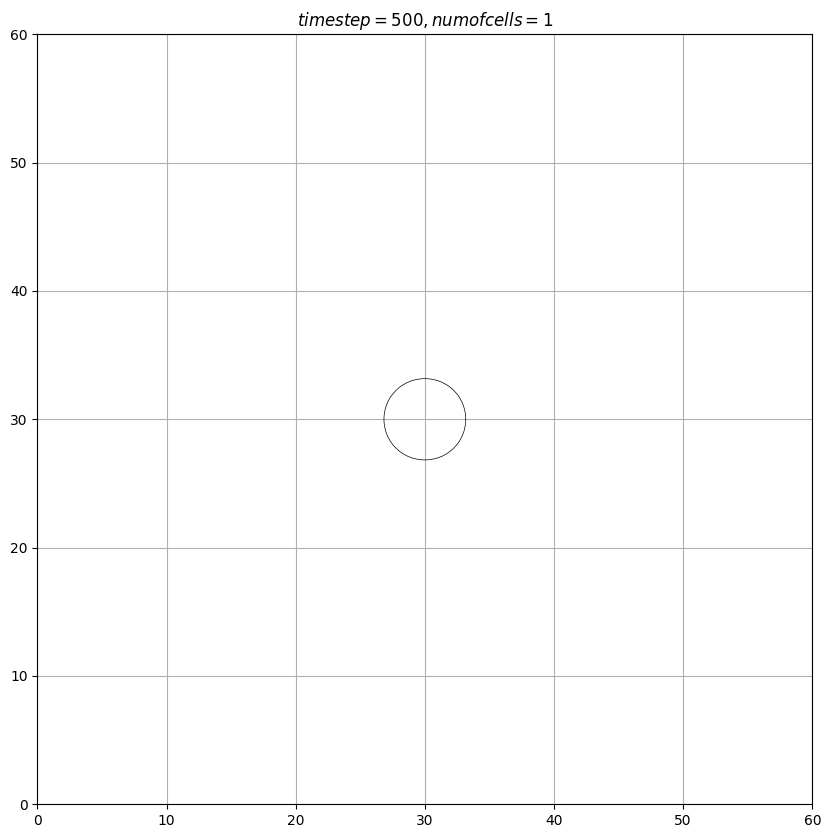

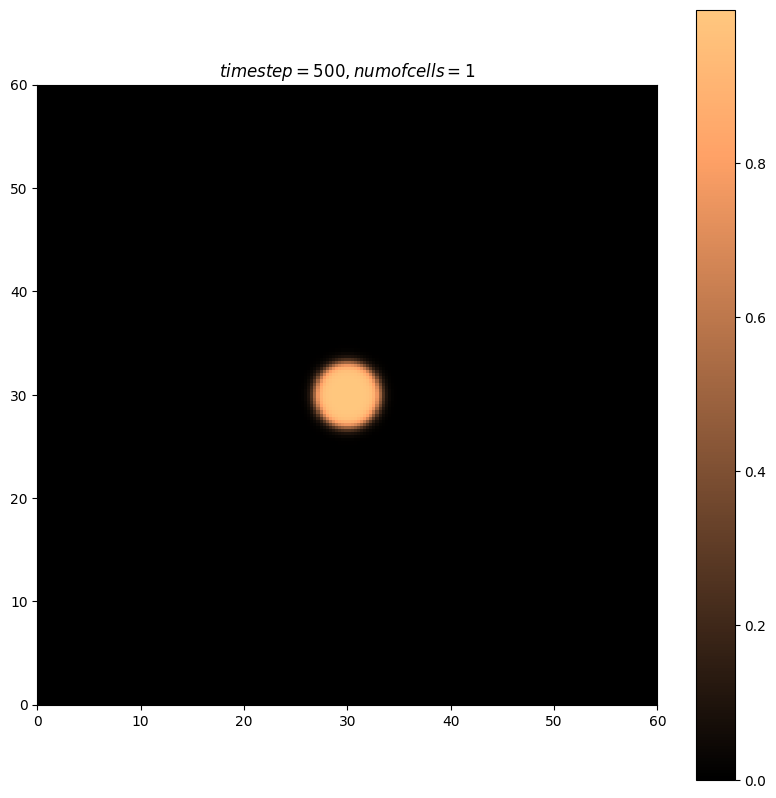

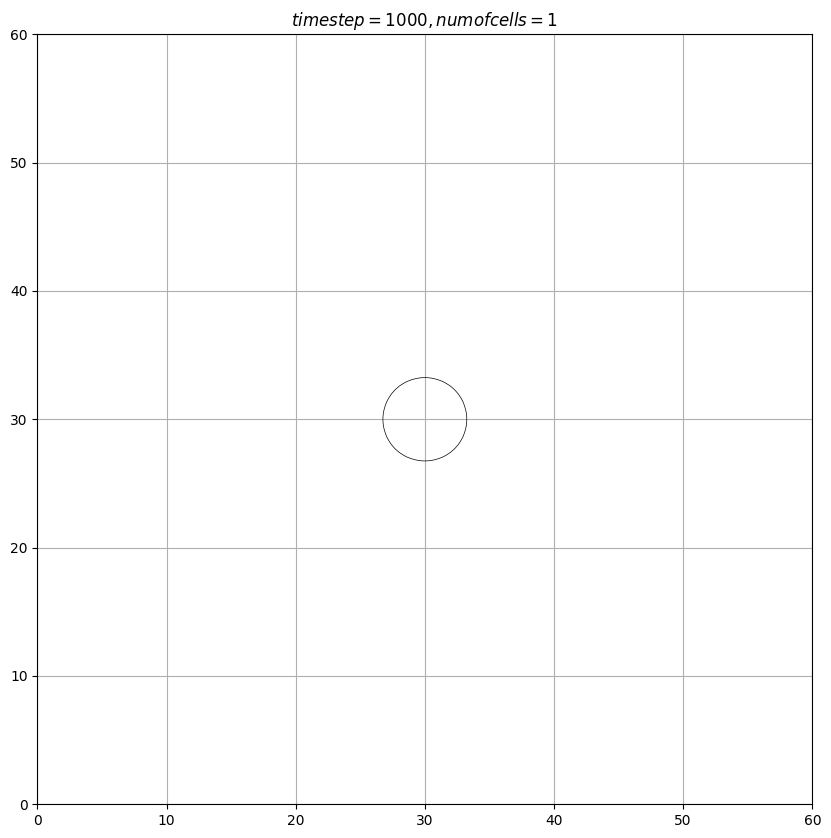

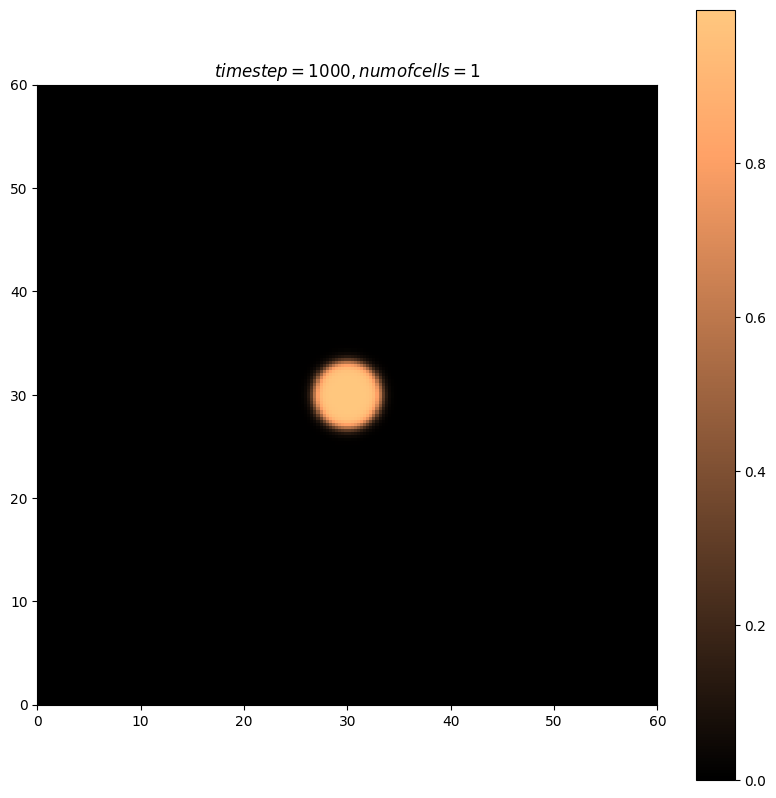

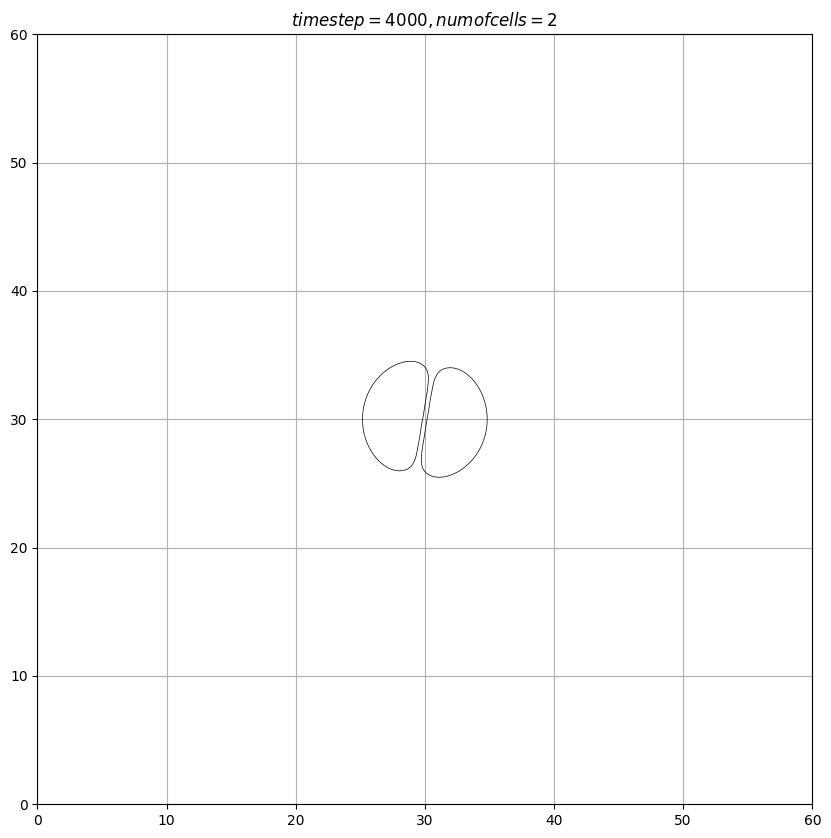

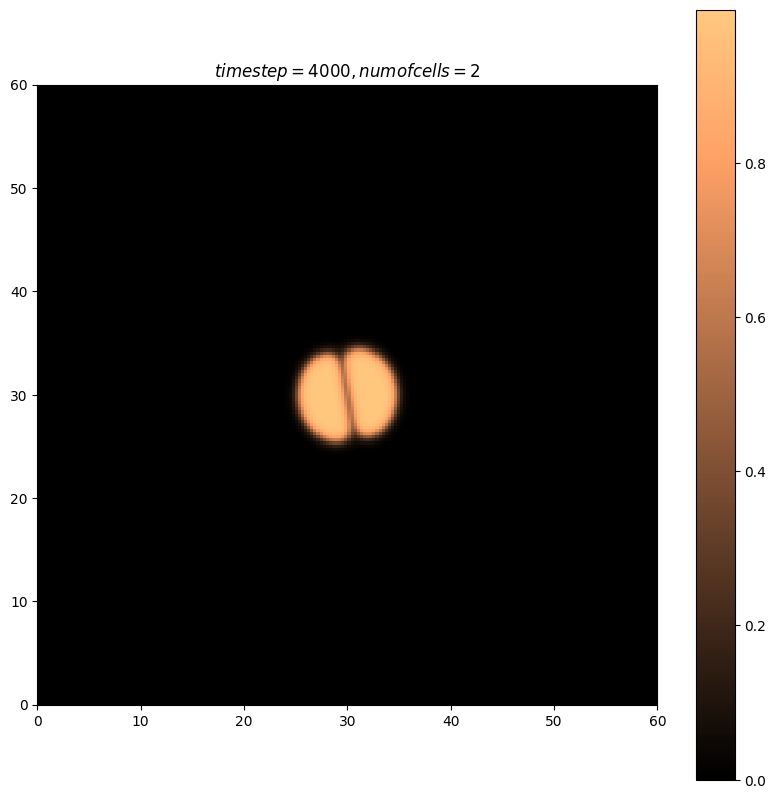

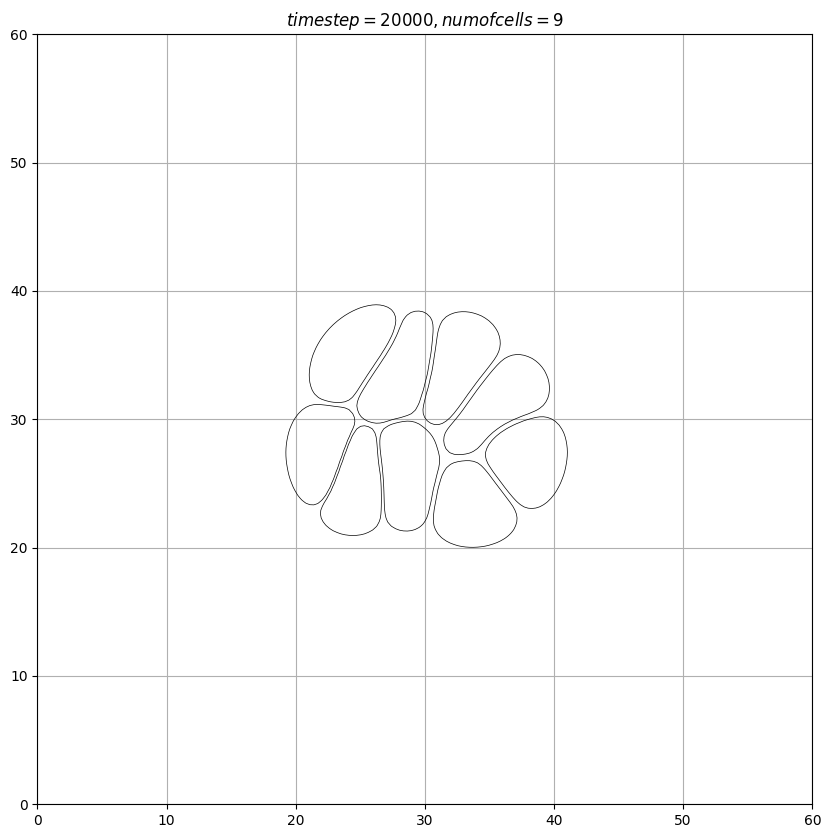

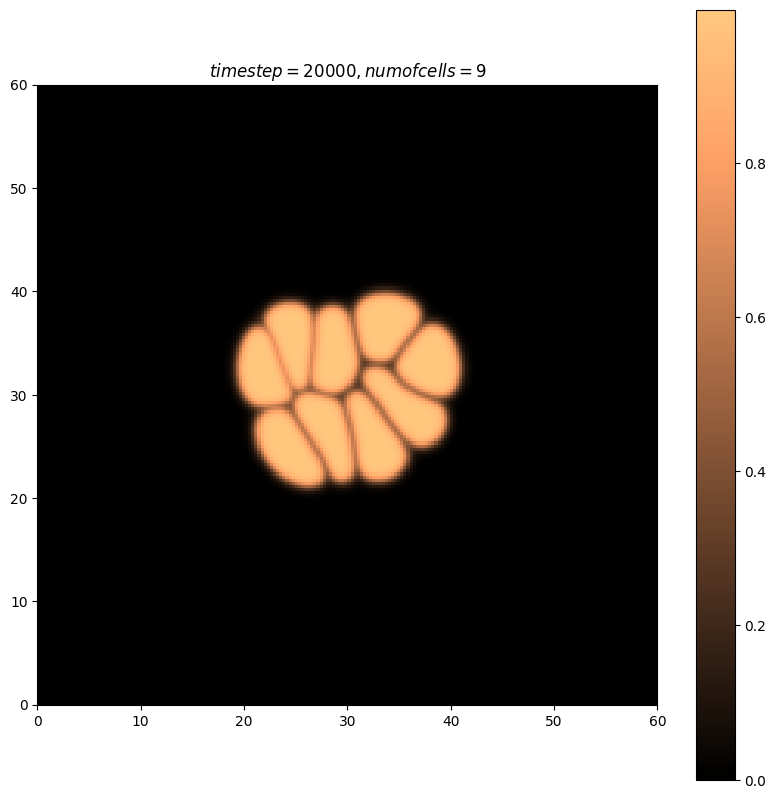

KeyboardInterrupt: 

In [129]:
Lx, Ly = 10, 10
dt = 0.1
dx = 0.05
dy = 0.05
Nx, Ny = int(Lx/dx), int(Ly/dy)

# parametry typów komórek

tau_u = 1
D = [0.001]

eta_s = [0]
eta = [[0]]
gamma = [0]
alpha = [1]
beta = [[1]]
beta_s = [0]

V_max = [1]


L = 1



smoothness = 10

#u = [[generate_cell(5,4.49,0.5,smoothness),generate_cell(5,5.51,0.5,smoothness)]]
u = [[generate_cell(5,5,0.5,smoothness)]]
phi_arr = [sum_u(u,0)]

s = np.zeros((Nx,Ny))

#pos1 = take_position(u,0,0)
#pos2 = take_position(u,0,1)

#vol1 = volume(u,0,0)
#vol2 = volume(u,0,1)

plt.figure(figsize=(10, 10))
plot_all(u,0,0,2)
#plot_value(phi_calc(u,0),0,1)
#plt.colorbar()
plt.show()

dt = 0.01
for t in range(400000):
    numOfCells = len(u[0])
    for n in range(numOfCells):
        phi_arr = [sum_u(u,0)]
        u[0][n] += dt * time_differential_equation(u, 0, n, s, phi_arr)
        cell_divide(u,0,n,0.93,smoothness)
    if t==1 or t==100 or t==500 or t==1000 or t==4000 or t==20000 or t==100000:
        plt.figure(figsize=(10, 10))
        plot_all(u,0,t,len(u[0]))
        plt.show()
        plt.figure(figsize=(10, 10))
        plot_value(phi_calc(u,0),t,len(u[0]))
        plt.colorbar()
        plt.show()
        

#pos11 = take_position(u,0,0)
#pos21 = take_position(u,0,1)

#print("change in position:")
#print(-pos1[1]+pos11[1])
#print(-pos2[1]+pos21[1],"\n")

#print("change in volume:")
#print(volume(u,0,0)-vol1)
#print(volume(u,0,1)-vol2)

plt.figure(figsize=(10, 10))
plot_all(u,0,t,len(u[0]))
plt.show()
plt.figure(figsize=(10, 10))
plot_value(phi_calc(u,0),t,len(u[0]))
plt.colorbar()
plt.show()


saved figure at t=0


KeyboardInterrupt: 

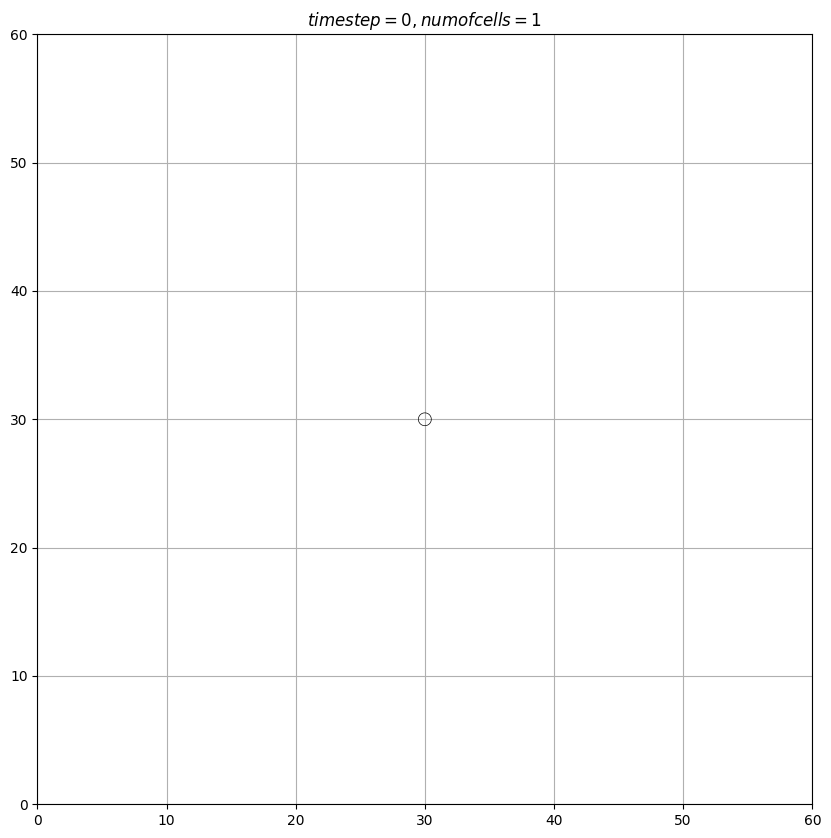

In [12]:
Lx, Ly = 60, 60
dt = 0.01
dx = 0.05
dy = 0.05
Nx, Ny = int(Lx/dx), int(Ly/dy)

# parametry typów komórek

tau_u = 1
D = [0.001]

eta_s = [0]
eta = [[0]]
gamma = [0]
alpha = [1]
beta = [[1]]
beta_s = [0]

V_max = [1]

L = 1



time_steps = 3000
dt = 0.05

u = [[]]
phi_arr = []

smoothness = 10

u[0].append(generate_cell(30,30,0.5,smoothness))

s = np.zeros((Nx,Ny))

phi_arr.append(sum_u(u,0))


prevlen=0
for t in range(time_steps):
    numOfCells=len(u[0])
    if numOfCells>prevlen:
    #if t==40:
        #wymusza jeszcze jedno wykonanie pętli przed wyrysowaniem
        #u[0][n] += dt * time_differential_equation(u, 0, n, s, phi)
        #cell_divide(u,0,n,0.83,10)
        #t += 1

        prevlen = len(u[0])
        numOfCells = prevlen
        
        #plt.figure(figsize=(6, 6))
        #plot_value(phi_calc(u,0), t, numOfCells)
        #plt.show()
        
        #plot_contour(phi_calc(u,0), t, numOfCells)
        
        plt.figure(figsize=(10, 10))
        plot_all(u, 0, t, numOfCells)
        plt.savefig(f"smoothness_{smoothness}-time_{t}-numOfCells_{numOfCells}.png", dpi=100)
        print(f"saved figure at t={t}")

    for n in range(numOfCells):
        u[0][n] += dt * time_differential_equation(u, 0, n, s, phi_arr)
        for i in range(len(u)):
            phi_arr[i] = sum_u(u,i)
        cell_divide(u,0,n,0.93,smoothness)
